In [2]:
COLAB_MODE = False
# google colab shenanigans
if COLAB_MODE:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir /content/data
    !gdown 1-5W-S5e7CKsJ9uY9uVXIyxgbcZZNYBrp
    !mv old-tsp-data.tar.gz /content/data/
    !tar -xzvf data/old-tsp-data.tar.gz -C /content/data/

    !git clone https://github.com/whong92/deep-ls.git
    %cd deep-ls

    data_root = '/content/data/tsp-data/'
    model_root = '/content/drive/MyDrive/colab_data/deep-ls/'
else:
    data_root = '../graph-convnet-tsp/data/'
    model_root = '.'

In [3]:
import cv2
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

from deepls.TSP2OptEnv import TSP2OptEnv

font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [4]:
from deepls.agent import GRCNCriticBaselineAgent
from torch import nn
import torch
from tqdm.notebook import tqdm

In [5]:
env = TSP2OptEnv(max_num_steps=50, num_nodes=50, data_f=f'{data_root}/tsp50_concorde.txt', shuffle_data=True)
env.reset()

In [11]:
env_val = TSP2OptEnv(max_num_steps=50, num_nodes=50, data_f=f'{data_root}/tsp50_test_concorde.txt', shuffle_data=False)
env_val.reset()

In [12]:
agent_config = {
    'replay_buffer_size': 2,
    'minibatch_sz': 32,
    'policy_optimize_every': 2,
    'critic_optimize_every': 1,
    'model': {   
        "voc_edges_in": 3,
        "hidden_dim": 128,
        "num_layers": 15,
        "mlp_layers": 3,
        "aggregation": "mean",
        "node_dim": 2,
        'dont_optimize_policy_steps': 10000,
    },
    'optim': {
        'step_size': 1e-7, 
        'step_size_critic': 2e-6, 
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'device': 'cuda'
}

val_every = 1000
val_episodes = 100
start_episode = 0
train_episodes = 40000

In [13]:
def val_agent(env, agent, num_episode=200):
    rewards = []
    starts = []
    opts = []
    env.init()
    
    # evaluation mode
    agent.set_eval()
    for episode in tqdm(range(num_episode), leave=False):
        env.reset()
        state = env.get_state()
        action = agent.agent_start(state)
        starts.append(state[0].tour_len)
        while True:
            # Take a random action
            state, reward, done = env.step(action)

            if done == True:
                agent.agent_end(reward)
                reward = state[1].tour_len
                rewards.append(reward)
                opts.append(state[0].opt_tour_len)
                break
            else:
                action = agent.agent_step(reward, state)
    opt_gap = np.array(rewards) / np.array(opts) - 1.
    agent.set_train()
    return np.mean(opt_gap)

In [14]:
def moving_average(arr, c=100):
    return np.convolve(arr, np.ones(shape=(100,))/100., mode='valid')

In [15]:
agent = GRCNCriticBaselineAgent()
agent.agent_init(agent_config)

In [16]:
# for g in agent.optimizer.param_groups:
#     g['lr'] = 1e-7
# for g in agent.critic_optimizer.param_groups:
#     g['lr'] = 2e-6

In [ ]:
# agent.load(f'{model_root}/model-15-layer-RGCN-20-nodes-2022-06-11.ckpt')

In [ ]:
rewards = []
starts = []
opts = []
env.reset()
rolling_baseline = env.state.tour_len
rb_step_size = 0.005
rbs = []
critic_baseline = []
per_improve = []
ve_error = []
train_opt_gaps = []
val_opt_gaps = []

agent.set_train()
pbar = tqdm(range(start_episode, start_episode + train_episodes))
for episode in pbar:
    env.reset()
    state = env.get_state()
    action = agent.agent_start(state)
    starts.append(state[0].tour_len)
    best = float("inf")
    while True:
        # Take a random action
        state, reward, done = env.step(action)

        if done == True:
            agent.agent_end(reward)
            reward = state[1].tour_len
            rewards.append(reward)
            rolling_baseline = rolling_baseline * (1. - rb_step_size) + reward * rb_step_size
            per_improve.append(-reward / starts[-1])
            rbs.append(rolling_baseline)
            ve_error.append(agent.critic_loss_val)
            opts.append(state[0].opt_tour_len)
            train_opt_gaps.append(rewards[-1] / opts[-1] - 1.)
            break
        else:
            action = agent.agent_step(reward, state)
    
    if (episode + 1) % val_every == 0 and episode > 0:
        val_opt_gap = val_agent(env_val, agent, val_episodes)
        val_opt_gaps.append(val_opt_gap)
        agent.save(f'{model_root}/model-15-layer-RGCN-20-nodes-{episode:05d}-val-{val_opt_gap:.3f}.ckpt')
    
    desc = f"train opt gap = {train_opt_gaps[-1]:.3f}"
    if len(val_opt_gaps) > 0:
        desc += f" val opt gap = {val_opt_gaps[-1]:.3f}"
    
    pbar.set_description(desc)

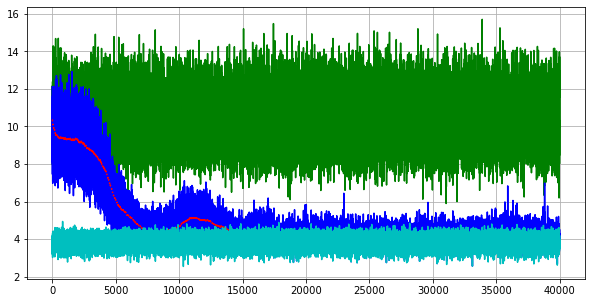

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(starts), color='g')
plt.plot(np.array(rewards), color='b')
# plt.plot(np.array(bests), color='r')
plt.plot(np.array(rbs), 'r:')
plt.plot(np.array(opts), 'c')
plt.grid()

In [20]:
ma_opt_gap = moving_average(np.array(train_opt_gaps))

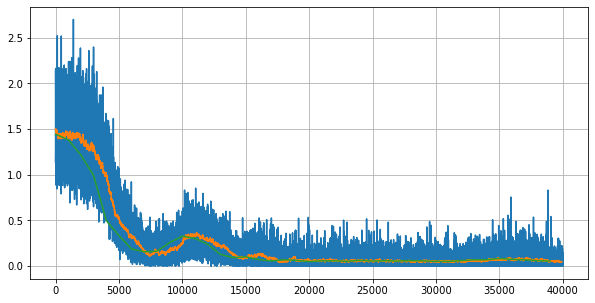

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_opt_gaps)
plt.plot(ma_opt_gap)
plt.plot(np.arange(len(val_opt_gaps)) * val_every + 1, val_opt_gaps)
plt.grid()

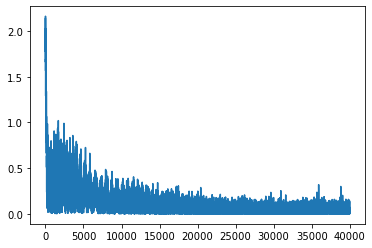

In [24]:
plt.plot(ve_error)

In [25]:
agent.save(f'{model_root}/model-15-layer-RGCN-20-nodes-2022-06-11.ckpt')